In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.utils import save_image
import torchvision
import numpy as np
import matplotlib.pylab as plt
import os
import cv2
import math
from math import log2
from tqdm import tqdm

In [69]:
!nvidia-smi

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

Mon Jan 20 11:27:30 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.06       Driver Version: 522.06       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000   WDDM  | 00000000:01:00.0  On |                  Off |
| 64%   80C    P3    95W / 300W |  26610MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [70]:
# Basic
RESOLUTION = 256
IMG_CHANNELS = 1
BATCH_SIZES = [512, 512, 256, 128, 64, 64, 32]
LAMBDA_GP = 10
LEARNING_RATE = 1e-3
PROGRESSIVE_EPOCHS = [20, 20, 40, 60, 80, 120, 160]
SAVE_INTERVAL = 10

# Optional
FIRST_IMG_SIZE = 4
Z_DIM = 512
W_DIM = 512
IN_CHANNELS = 512
factors = [1,1,1,1/2,1/4,1/8,1/16,1/32]

In [71]:
DATASET = "./dataset"
AUGMENTED_DATASET = "./augmented_dataset"

def data_augmentation(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    transformations = [
        lambda x: x,
        lambda x: cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE),
        lambda x: cv2.rotate(x, cv2.ROTATE_90_COUNTERCLOCKWISE),
        lambda x: cv2.rotate(x, cv2.ROTATE_180),
        lambda x: cv2.flip(x, 1),
        lambda x: cv2.flip(cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE), 1),
        lambda x: cv2.flip(cv2.rotate(x, cv2.ROTATE_90_COUNTERCLOCKWISE), 1),
        lambda x: cv2.flip(cv2.rotate(x, cv2.ROTATE_180), 1),
    ]

    for folder_name in os.listdir(input_folder):
        input_folder_path = os.path.join(input_folder, folder_name)
        output_folder_path = os.path.join(output_folder, folder_name)

        if not os.path.exists(output_folder_path):
            os.makedirs(output_folder_path)

        for filename in os.listdir(input_folder_path):
            filepath = os.path.join(input_folder_path, filename)
            img = cv2.imread(filepath)
            if img is None:
                continue
            
            for i, transform in enumerate(transformations):
                augmented_img = transform(img)
                output_filepath = os.path.join(output_folder_path, f"{os.path.splitext(filename)[0]}_aug{i}.tif")
                cv2.imwrite(output_filepath, augmented_img)

def get_loader(resolution):
    transform = transforms.Compose([
        transforms.Resize((resolution, resolution)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])
    batch_size = BATCH_SIZES[int(log2(resolution/4))]
    dataset = datasets.ImageFolder(AUGMENTED_DATASET, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader, dataset

data_augmentation(DATASET, AUGMENTED_DATASET)

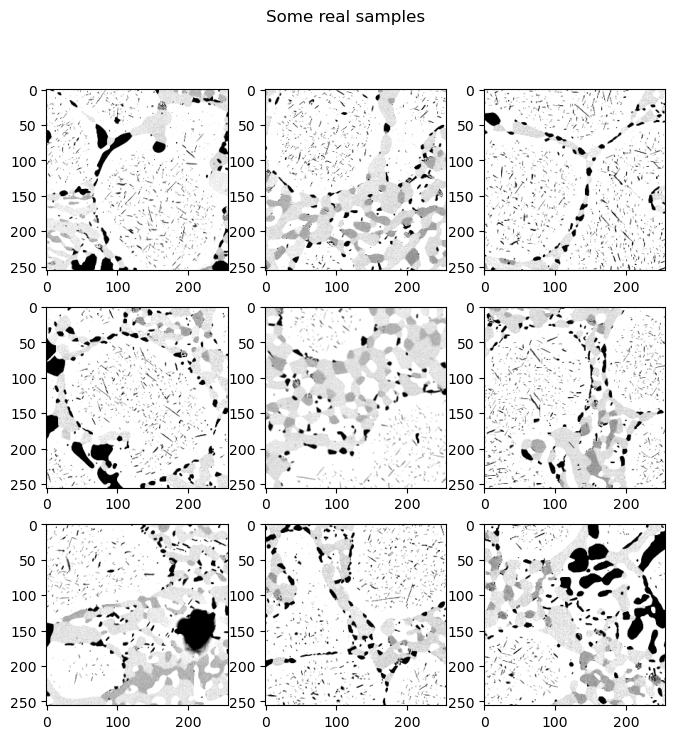

In [72]:
def check_loader():
    loader,_ = get_loader(RESOLUTION)
    MoSiBTiC,_  = next(iter(loader))
    _,ax     = plt.subplots(3,3,figsize=(8,8))
    plt.suptitle('Some real samples')
    ind = 0
    for k in range(3):
        for kk in range(3):
            image = MoSiBTiC[ind]
            if image.shape[0] == 1:  # Check if the image is grayscale
                ax[k][kk].imshow(image.squeeze(), cmap='gray')
            else:
                ax[k][kk].imshow((image.permute(1,2,0) + 1) / 2)
            ind += 1
check_loader()

In [73]:
class EqualizedLinear(nn.Module):
    def __init__(self, in_dim, out_dim, bias=True):
        super(EqualizedLinear, self).__init__()
        self.linear = nn.Linear(in_dim, out_dim, bias=bias)
        nn.init.normal_(self.linear.weight, mean=0.0, std=1.0 / np.sqrt(in_dim))
        if bias:
            nn.init.zeros_(self.linear.bias)
        self.scale = (2 / in_dim) ** 0.5

    def forward(self, x):
        return self.linear(x) * self.scale

In [74]:
class PixelNorm(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(PixelNorm, self).__init__()
        self.epsilon = epsilon
    
    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim = 1, keepdim = True) + self.epsilon)

In [75]:
class MappingNetwork(nn.Module):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            PixelNorm(),
            EqualizedLinear(z_dim, w_dim),
            nn.LeakyReLU(0.2),
            EqualizedLinear(w_dim, w_dim),
            nn.LeakyReLU(0.2),
            EqualizedLinear(w_dim, w_dim),
            nn.LeakyReLU(0.2),
            EqualizedLinear(w_dim, w_dim),
            nn.LeakyReLU(0.2),
            EqualizedLinear(w_dim, w_dim),
            nn.LeakyReLU(0.2),
            EqualizedLinear(w_dim, w_dim),
            nn.LeakyReLU(0.2),
            EqualizedLinear(w_dim, w_dim),
            nn.LeakyReLU(0.2),
            EqualizedLinear(w_dim, w_dim),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self,z):
        return self.mapping(z)

In [76]:
class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.style_scale   = nn.Linear(w_dim, channels)
        self.style_bias    = nn.Linear(w_dim, channels)

    def forward(self,x,w):
        x = self.instance_norm(x)
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        style_bias  = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return style_scale * x + style_bias

In [77]:
class EqualizedConv2d(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1,bias = True
    ):
        super(EqualizedConv2d, self).__init__()
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        fan_in = in_channels * kernel_size * kernel_size
        self.scale = 1 / math.sqrt(fan_in)
        
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels))
        else:
            self.bias = None
        
        self.stride = stride
        self.padding = padding

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.conv2d(
            x, self.weight * self.scale, bias=self.bias, stride=self.stride, padding=self.padding
        )

In [78]:
# WSConv2d is not used in this script.
class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

In [79]:
class NoiseInjection(nn.Module):
    def __init__(self, channels):
        super(NoiseInjection, self).__init__()
        self.weight = nn.Parameter(torch.zeros(1,channels,1,1))

    def forward(self, x, noise=None):
        noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device = x.device)
        return x + self.weight * noise

In [80]:
class GeneratorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, w_dim):
        super(GeneratorBlock, self).__init__()
        self.conv1 = EqualizedConv2d(in_channels, out_channels)
        self.conv2 = EqualizedConv2d(out_channels, out_channels)
        self.activation = nn.LeakyReLU(0.2, inplace=True)
        self.noise_injection1 = NoiseInjection(out_channels)
        self.noise_injection2 = NoiseInjection(out_channels)
        self.adain1 = AdaIN(out_channels, w_dim)
        self.adain2 = AdaIN(out_channels, w_dim)

    def forward(self, x, w):
        x = self.adain1(self.activation(self.noise_injection1(self.conv1(x))), w)
        x = self.adain2(self.activation(self.noise_injection2(self.conv2(x))), w)
        return x

In [81]:
class Generator(nn.Module):
    def __init__(self, z_dim, w_dim, in_channels, img_channels):
        super(Generator, self).__init__()
        self.constant = nn.Parameter(torch.ones(1, in_channels, 4, 4))
        self.mapping_network = MappingNetwork(z_dim, w_dim)
        self.first_adain1 = AdaIN(in_channels, w_dim)
        self.first_adain2 = AdaIN(in_channels, w_dim)
        self.first_noise1 = NoiseInjection(in_channels)
        self.first_noise2 = NoiseInjection(in_channels)
        self.first_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.activation = nn.LeakyReLU(0.2, inplace=True)
        
        self.first_torgb = EqualizedConv2d(in_channels, img_channels, kernel_size=1, stride=1, padding=0)

        self.prog_blocks, self.to_rgbs = (
            nn.ModuleList([]),
            nn.ModuleList([self.first_torgb])
        )
        
        for i in range(len(factors)-1):
            in_channels_c = int(in_channels * factors[i])
            out_channels_c = int(in_channels * factors[i+1])
            self.prog_blocks.append(GeneratorBlock(in_channels_c, out_channels_c, w_dim))
            self.to_rgbs.append(EqualizedConv2d(out_channels_c, img_channels, kernel_size=1, stride=1, padding=0))

    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, z, alpha, steps):
        w = self.mapping_network(z)
        x = self.first_adain1(self.first_noise1(self.constant), w)
        x = self.first_conv(x)
        out = self.first_adain2(self.activation(self.first_noise2(x)), w)

        if steps == 0:
            return self.first_torgb(x)
        
        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode='bilinear')
            out = self.prog_blocks[step](upscaled, w)

        final_upscaled = self.to_rgbs[steps-1](upscaled)
        final_out = self.to_rgbs[steps](out)

        return self.fade_in(alpha, final_upscaled, final_out)

In [82]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DiscriminatorBlock, self).__init__()
        self.conv1 = EqualizedConv2d(in_channels, out_channels)
        self.conv2 = EqualizedConv2d(out_channels, out_channels)
        self.activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        return x

In [83]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.from_rgbs = nn.ModuleList([]), nn.ModuleList([])
        self.activation = nn.LeakyReLU(0.2, inplace=True)

        for i in range(len(factors)-1, 0, -1):
            in_channels_c = int(in_channels * factors[i])
            out_channels_c = int(in_channels * factors[i-1])
            self.prog_blocks.append(DiscriminatorBlock(in_channels_c, out_channels_c))
            self.from_rgbs.append(EqualizedConv2d(img_channels, in_channels_c, kernel_size=1, stride=1, padding=0))

        self.first_fromrgb = EqualizedConv2d(img_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.from_rgbs.append(self.first_fromrgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )

        self.final_block = nn.Sequential(
            EqualizedConv2d(in_channels+1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            EqualizedConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2, inplace=True),
            EqualizedConv2d(in_channels, 1, kernel_size=1, padding=0, stride=1),
        )

    def fade_in(self, alpha, downscaled, out):
        return alpha * out + (1 - alpha) * downscaled
    
    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        cur_step = len(self.prog_blocks) - steps
        out = self.activation(self.from_rgbs[cur_step](x))

        if steps == 0:
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)
        
        downscaled = self.activation(self.from_rgbs[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)


In [84]:
def gradient_penalty(discriminator, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    mixed_scores = discriminator(interpolated_images, alpha, train_step)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [85]:
def discriminator_loss(discriminator_real, discriminator_fake, lambda_gp, gp):
    loss = (-(torch.mean(discriminator_real) - torch.mean(discriminator_fake)) + lambda_gp * gp + (0.001) * torch.mean(discriminator_real ** 2))
    return loss

def generator_loss(discriminator_fake):
    loss = -torch.mean(discriminator_fake)
    return loss

In [86]:
def generate_examples(generator, step, epoch, n=100):
    generator.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            z = torch.randn(1, Z_DIM).to(DEVICE)
            img = generator(z, alpha, step)
            if not os.path.exists(f'saved_examples/step{step}/epoch{epoch+1}'):
                os.makedirs(f'saved_examples/step{step}/epoch{epoch+1}')
            save_image(img*0.5+0.5, f"saved_examples/step{step}/epoch{epoch+1}/img_{i}.png")
    generator.train()

In [87]:
def save_loss_value(loss_log):
    if not os.path.exists(f'saved_loss_value'):
        os.makedirs(f'saved_loss_value')
    log_path = os.path.join("./saved_loss_value", "loss_log.txt")
    with open(log_path, "w") as f:
        for epoch, (g_loss, d_loss) in enumerate(zip(loss_log["Generator Loss"], loss_log["Discriminator Loss"]), 1):
            f.write(f"Epoch {epoch}: Generator Loss: {g_loss:.10f}, Discriminator Loss: {d_loss:.10f}\n")
    print("Saved loss log.")

In [88]:
def save_model(discriminator, generator, step, epoch):
    generator.eval()
    discriminator.eval()
    if not os.path.exists(f'saved_models/step{step}'):
        os.makedirs(f'saved_models/step{step}')
    torch.save(generator.state_dict(), f"saved_models/step{step}/generator_step{step}_epoch{epoch+1}.pth")
    torch.save(discriminator.state_dict(), f"saved_models/step{step}/discrminator_step{step}_epoch{epoch+1}.pth")
    print("Models were stored.")
    generator.train()
    discriminator.train()

In [89]:
def train_function(
        discriminator, generator, loader, dataset, step, alpha, optimizer_d, optimizer_g
):
    loop = tqdm(loader, leave=True)
    
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]
        z = torch.randn(cur_batch_size, Z_DIM).to(DEVICE)
        fake = generator(z, alpha, step)
        discriminator_real = discriminator(real, alpha, step)
        discriminator_fake = discriminator(fake.detach(), alpha, step)
        gp = gradient_penalty(discriminator, real, fake, alpha, step, DEVICE)
        loss_d = discriminator_loss(discriminator_real, discriminator_fake, LAMBDA_GP, gp)

        discriminator.zero_grad()
        loss_d.backward()
        optimizer_d.step()

        discriminator_fake2 = discriminator(fake, alpha, step)
        loss_g = generator_loss(discriminator_fake2)

        generator.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        alpha += cur_batch_size / (
            PROGRESSIVE_EPOCHS[step] * 0.5 * len(dataset)
        )
        alpha = min(alpha, 1)

        loop.set_postfix(
            gp = gp.item(),
            loss_d = loss_d.item(),
            loss_g = loss_g.item()
        )
    return alpha, loss_d, loss_g

In [90]:
generator = Generator(Z_DIM, W_DIM, IN_CHANNELS, IMG_CHANNELS).to(DEVICE)
discriminator = Discriminator(IN_CHANNELS, IMG_CHANNELS).to(DEVICE)

optimizer_g = optim.Adam([
    {'params': [param for name, param in generator.named_parameters() if 'map' not in name]},
    {'params': generator.mapping_network.parameters(), 'lr': 1e-5}
], lr=LEARNING_RATE, betas=(0.0, 0.99))
optimizer_d = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))

generator.train()
discriminator.train()

loss_log = {
    "Generator Loss": [],
    "Discriminator Loss": []
}

step = int(log2(FIRST_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-7
    loader, dataset = get_loader(4 * 2 ** step)
    print('Current Image Size: ' + str(4 * 2**step))
    
    for epoch in range(num_epochs):
        print(f'Epoch[{epoch + 1} / {num_epochs}]')

        alpha, loss_d, loss_g = train_function(
            discriminator, generator, loader, dataset, step, alpha, optimizer_d, optimizer_g
        )

        loss_log["Generator Loss"].append(loss_g)
        loss_log["Discriminator Loss"].append(loss_d)

        if (epoch + 1) % SAVE_INTERVAL == 0:
            generate_examples(generator, step, epoch)
            save_model(discriminator, generator, step, epoch)
            save_loss_value(loss_log)

    step += 1

Current Image Size: 4
Epoch[1 / 20]


100%|██████████| 35/35 [00:20<00:00,  1.67it/s, gp=0.0393, loss_d=1.4, loss_g=0.497]  


Epoch[2 / 20]


100%|██████████| 35/35 [00:20<00:00,  1.68it/s, gp=0.0225, loss_d=1.08, loss_g=-0.107] 


Epoch[3 / 20]


100%|██████████| 35/35 [00:21<00:00,  1.64it/s, gp=0.00872, loss_d=0.721, loss_g=-0.504] 


Epoch[4 / 20]


100%|██████████| 35/35 [00:22<00:00,  1.55it/s, gp=0.00614, loss_d=0.75, loss_g=-0.461]  


Epoch[5 / 20]


100%|██████████| 35/35 [00:21<00:00,  1.63it/s, gp=0.0309, loss_d=0.921, loss_g=-0.144]  


Epoch[6 / 20]


100%|██████████| 35/35 [00:22<00:00,  1.57it/s, gp=0.0474, loss_d=1.02, loss_g=-0.403]    


Epoch[7 / 20]


100%|██████████| 35/35 [00:26<00:00,  1.30it/s, gp=0.0016, loss_d=0.516, loss_g=-0.284]  


Epoch[8 / 20]


100%|██████████| 35/35 [00:27<00:00,  1.29it/s, gp=0.00305, loss_d=0.577, loss_g=-0.311]


Epoch[9 / 20]


100%|██████████| 35/35 [00:26<00:00,  1.32it/s, gp=0.0424, loss_d=1.02, loss_g=-0.344]  


Epoch[10 / 20]


100%|██████████| 35/35 [00:25<00:00,  1.36it/s, gp=0.0547, loss_d=1.08, loss_g=-0.179]   


Models were stored.
Saved loss log.
Epoch[11 / 20]


100%|██████████| 35/35 [00:24<00:00,  1.41it/s, gp=0.000302, loss_d=0.582, loss_g=-0.414] 


Epoch[12 / 20]


100%|██████████| 35/35 [00:22<00:00,  1.55it/s, gp=0.0393, loss_d=0.841, loss_g=-0.412]  


Epoch[13 / 20]


100%|██████████| 35/35 [00:23<00:00,  1.47it/s, gp=0.0248, loss_d=0.684, loss_g=-0.0891]


Epoch[14 / 20]


100%|██████████| 35/35 [00:24<00:00,  1.45it/s, gp=0.0177, loss_d=0.73, loss_g=-0.252]   


Epoch[15 / 20]


100%|██████████| 35/35 [00:23<00:00,  1.48it/s, gp=0.000452, loss_d=0.572, loss_g=-0.33] 


Epoch[16 / 20]


100%|██████████| 35/35 [00:22<00:00,  1.56it/s, gp=0.0613, loss_d=1.14, loss_g=-0.669]   


Epoch[17 / 20]


100%|██████████| 35/35 [00:25<00:00,  1.39it/s, gp=0.0959, loss_d=1.36, loss_g=-0.737]   


Epoch[18 / 20]


100%|██████████| 35/35 [00:24<00:00,  1.43it/s, gp=0.00371, loss_d=0.452, loss_g=-0.518]


Epoch[19 / 20]


100%|██████████| 35/35 [00:27<00:00,  1.26it/s, gp=0.0562, loss_d=0.961, loss_g=-0.55]  


Epoch[20 / 20]


100%|██████████| 35/35 [00:27<00:00,  1.29it/s, gp=0.00342, loss_d=0.414, loss_g=-0.514]


Models were stored.
Saved loss log.
Current Image Size: 8
Epoch[1 / 20]


100%|██████████| 35/35 [00:34<00:00,  1.02it/s, gp=0.00156, loss_d=-1.18, loss_g=-2.14] 


Epoch[2 / 20]


100%|██████████| 35/35 [00:33<00:00,  1.04it/s, gp=0.00139, loss_d=0.738, loss_g=-2.87] 


Epoch[3 / 20]


100%|██████████| 35/35 [00:33<00:00,  1.05it/s, gp=0.0137, loss_d=1.27, loss_g=-5.76]  


Epoch[4 / 20]


100%|██████████| 35/35 [00:33<00:00,  1.03it/s, gp=0.00646, loss_d=1.04, loss_g=-3.81]


Epoch[5 / 20]


100%|██████████| 35/35 [00:34<00:00,  1.03it/s, gp=0.00419, loss_d=-0.347, loss_g=3.73] 


Epoch[6 / 20]


100%|██████████| 35/35 [00:33<00:00,  1.05it/s, gp=0.00241, loss_d=-0.6, loss_g=1.86]  


Epoch[7 / 20]


100%|██████████| 35/35 [00:32<00:00,  1.07it/s, gp=0.00952, loss_d=-0.767, loss_g=-0.291] 


Epoch[8 / 20]


100%|██████████| 35/35 [00:33<00:00,  1.05it/s, gp=0.00953, loss_d=-0.616, loss_g=1.24]    


Epoch[9 / 20]


100%|██████████| 35/35 [00:34<00:00,  1.02it/s, gp=0.00212, loss_d=-0.644, loss_g=-0.566]  


Epoch[10 / 20]


100%|██████████| 35/35 [00:33<00:00,  1.05it/s, gp=0.00232, loss_d=-0.903, loss_g=0.633] 


Models were stored.
Saved loss log.
Epoch[11 / 20]


100%|██████████| 35/35 [00:33<00:00,  1.03it/s, gp=0.00307, loss_d=-0.747, loss_g=0.357]


Epoch[12 / 20]


100%|██████████| 35/35 [00:31<00:00,  1.12it/s, gp=0.000838, loss_d=-0.873, loss_g=1.42]


Epoch[13 / 20]


100%|██████████| 35/35 [00:30<00:00,  1.15it/s, gp=0.0049, loss_d=-0.908, loss_g=0.584]  


Epoch[14 / 20]


100%|██████████| 35/35 [00:31<00:00,  1.13it/s, gp=0.000881, loss_d=-0.784, loss_g=0.863]


Epoch[15 / 20]


100%|██████████| 35/35 [00:31<00:00,  1.11it/s, gp=0.00629, loss_d=-0.814, loss_g=0.627] 


Epoch[16 / 20]


100%|██████████| 35/35 [00:32<00:00,  1.09it/s, gp=0.000888, loss_d=-0.878, loss_g=1.65]  


Epoch[17 / 20]


100%|██████████| 35/35 [00:29<00:00,  1.21it/s, gp=0.00826, loss_d=-0.756, loss_g=0.924] 


Epoch[18 / 20]


100%|██████████| 35/35 [00:33<00:00,  1.06it/s, gp=0.0014, loss_d=-0.901, loss_g=1.52]   


Epoch[19 / 20]


100%|██████████| 35/35 [00:32<00:00,  1.08it/s, gp=0.0109, loss_d=-0.781, loss_g=0.638]  


Epoch[20 / 20]


100%|██████████| 35/35 [00:33<00:00,  1.03it/s, gp=0.00337, loss_d=-0.826, loss_g=1.68]  


Models were stored.
Saved loss log.
Current Image Size: 16
Epoch[1 / 40]


100%|██████████| 69/69 [01:14<00:00,  1.09s/it, gp=0.00492, loss_d=-1.55, loss_g=5.5]  


Epoch[2 / 40]


100%|██████████| 69/69 [01:14<00:00,  1.08s/it, gp=0.00963, loss_d=1.44, loss_g=-7.22]  


Epoch[3 / 40]


100%|██████████| 69/69 [01:13<00:00,  1.07s/it, gp=0.0121, loss_d=1.24, loss_g=-0.979] 


Epoch[4 / 40]


100%|██████████| 69/69 [01:13<00:00,  1.07s/it, gp=0.0072, loss_d=1.04, loss_g=-1.47]   


Epoch[5 / 40]


100%|██████████| 69/69 [01:10<00:00,  1.03s/it, gp=0.0216, loss_d=1.1, loss_g=-0.666]   


Epoch[6 / 40]


100%|██████████| 69/69 [01:12<00:00,  1.05s/it, gp=0.00967, loss_d=0.918, loss_g=0.977]  


Epoch[7 / 40]


100%|██████████| 69/69 [01:12<00:00,  1.04s/it, gp=0.00369, loss_d=0.806, loss_g=1.9]    


Epoch[8 / 40]


100%|██████████| 69/69 [01:13<00:00,  1.07s/it, gp=0.00379, loss_d=1.02, loss_g=1.23]   


Epoch[9 / 40]


100%|██████████| 69/69 [01:13<00:00,  1.07s/it, gp=0.00145, loss_d=0.704, loss_g=-0.479] 


Epoch[10 / 40]


100%|██████████| 69/69 [01:13<00:00,  1.07s/it, gp=0.00386, loss_d=0.767, loss_g=-0.517]  


Models were stored.
Saved loss log.
Epoch[11 / 40]


100%|██████████| 69/69 [01:14<00:00,  1.08s/it, gp=0.011, loss_d=0.69, loss_g=-3.29]     


Epoch[12 / 40]


100%|██████████| 69/69 [01:14<00:00,  1.08s/it, gp=0.0104, loss_d=0.763, loss_g=-1.21]  


Epoch[13 / 40]


100%|██████████| 69/69 [01:12<00:00,  1.05s/it, gp=0.00457, loss_d=0.874, loss_g=0.315]  


Epoch[14 / 40]


100%|██████████| 69/69 [01:09<00:00,  1.01s/it, gp=0.00226, loss_d=0.764, loss_g=0.169]  


Epoch[15 / 40]


100%|██████████| 69/69 [01:12<00:00,  1.05s/it, gp=0.02, loss_d=0.732, loss_g=-0.933]    


Epoch[16 / 40]


100%|██████████| 69/69 [01:14<00:00,  1.09s/it, gp=0.00573, loss_d=0.657, loss_g=-1.3]   


Epoch[17 / 40]


100%|██████████| 69/69 [01:13<00:00,  1.07s/it, gp=0.00548, loss_d=0.738, loss_g=-0.647] 


Epoch[18 / 40]


100%|██████████| 69/69 [01:13<00:00,  1.07s/it, gp=0.00719, loss_d=0.529, loss_g=-0.635]


Epoch[19 / 40]


100%|██████████| 69/69 [01:13<00:00,  1.07s/it, gp=0.0151, loss_d=0.558, loss_g=-1.82]  


Epoch[20 / 40]


100%|██████████| 69/69 [01:14<00:00,  1.07s/it, gp=0.0254, loss_d=0.723, loss_g=0.241]   


Models were stored.
Saved loss log.
Epoch[21 / 40]


100%|██████████| 69/69 [01:13<00:00,  1.07s/it, gp=0.00531, loss_d=0.464, loss_g=-2.49]  


Epoch[22 / 40]


100%|██████████| 69/69 [01:11<00:00,  1.04s/it, gp=0.0116, loss_d=0.481, loss_g=-1.63]   


Epoch[23 / 40]


100%|██████████| 69/69 [01:10<00:00,  1.02s/it, gp=0.0324, loss_d=0.683, loss_g=-2.16]   


Epoch[24 / 40]


100%|██████████| 69/69 [01:13<00:00,  1.06s/it, gp=0.0109, loss_d=1.17, loss_g=2.45]    


Epoch[25 / 40]


100%|██████████| 69/69 [01:13<00:00,  1.07s/it, gp=0.00821, loss_d=0.523, loss_g=-1.05]  


Epoch[26 / 40]


100%|██████████| 69/69 [01:14<00:00,  1.08s/it, gp=0.0073, loss_d=0.577, loss_g=-0.993]  


Epoch[27 / 40]


100%|██████████| 69/69 [01:13<00:00,  1.07s/it, gp=0.0055, loss_d=0.646, loss_g=-1.05]  


Epoch[28 / 40]


100%|██████████| 69/69 [01:13<00:00,  1.06s/it, gp=0.0132, loss_d=0.684, loss_g=0.33]   


Epoch[29 / 40]


100%|██████████| 69/69 [01:13<00:00,  1.07s/it, gp=0.0131, loss_d=0.678, loss_g=0.774]   


Epoch[30 / 40]


100%|██████████| 69/69 [01:11<00:00,  1.03s/it, gp=0.00832, loss_d=0.641, loss_g=-0.415]


Models were stored.
Saved loss log.
Epoch[31 / 40]


100%|██████████| 69/69 [01:12<00:00,  1.04s/it, gp=0.00856, loss_d=0.835, loss_g=-1.47] 


Epoch[32 / 40]


100%|██████████| 69/69 [01:13<00:00,  1.07s/it, gp=0.011, loss_d=0.572, loss_g=-0.345]  


Epoch[33 / 40]


100%|██████████| 69/69 [01:13<00:00,  1.06s/it, gp=0.00303, loss_d=0.474, loss_g=-0.25] 


Epoch[34 / 40]


100%|██████████| 69/69 [01:14<00:00,  1.08s/it, gp=0.00682, loss_d=0.647, loss_g=-1.01]  


Epoch[35 / 40]


100%|██████████| 69/69 [01:15<00:00,  1.09s/it, gp=0.0155, loss_d=0.627, loss_g=-1.42]   


Epoch[36 / 40]


100%|██████████| 69/69 [01:14<00:00,  1.09s/it, gp=0.00497, loss_d=0.52, loss_g=-0.59]   


Epoch[37 / 40]


100%|██████████| 69/69 [01:14<00:00,  1.08s/it, gp=0.00511, loss_d=0.75, loss_g=0.858]  


Epoch[38 / 40]


100%|██████████| 69/69 [01:10<00:00,  1.02s/it, gp=0.00849, loss_d=0.571, loss_g=-0.316] 


Epoch[39 / 40]


100%|██████████| 69/69 [01:12<00:00,  1.05s/it, gp=0.00378, loss_d=0.555, loss_g=-1.17]  


Epoch[40 / 40]


100%|██████████| 69/69 [01:11<00:00,  1.04s/it, gp=0.00257, loss_d=0.531, loss_g=-0.198] 


Models were stored.
Saved loss log.
Current Image Size: 32
Epoch[1 / 60]


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, gp=0.0126, loss_d=0.797, loss_g=-0.247] 


Epoch[2 / 60]


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, gp=0.0227, loss_d=1.07, loss_g=-0.575] 


Epoch[3 / 60]


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, gp=0.00974, loss_d=1.19, loss_g=0.53]  


Epoch[4 / 60]


100%|██████████| 137/137 [02:02<00:00,  1.12it/s, gp=0.0086, loss_d=0.83, loss_g=-0.486]   


Epoch[5 / 60]


100%|██████████| 137/137 [02:01<00:00,  1.13it/s, gp=0.00754, loss_d=0.819, loss_g=-0.754] 


Epoch[6 / 60]


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, gp=0.00326, loss_d=1.11, loss_g=-0.463] 


Epoch[7 / 60]


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, gp=0.002, loss_d=0.807, loss_g=0.0152]  


Epoch[8 / 60]


100%|██████████| 137/137 [02:03<00:00,  1.11it/s, gp=0.00365, loss_d=0.788, loss_g=-2.49]


Epoch[9 / 60]


100%|██████████| 137/137 [02:02<00:00,  1.12it/s, gp=0.00467, loss_d=0.99, loss_g=-1.43]  


Epoch[10 / 60]


100%|██████████| 137/137 [02:03<00:00,  1.11it/s, gp=0.00509, loss_d=0.88, loss_g=-2.19]   


Models were stored.
Saved loss log.
Epoch[11 / 60]


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, gp=0.0175, loss_d=0.726, loss_g=-3.36]  


Epoch[12 / 60]


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, gp=0.0049, loss_d=0.657, loss_g=0.406]  


Epoch[13 / 60]


100%|██████████| 137/137 [02:03<00:00,  1.11it/s, gp=0.0194, loss_d=0.651, loss_g=-0.82]  


Epoch[14 / 60]


100%|██████████| 137/137 [02:02<00:00,  1.12it/s, gp=0.0267, loss_d=1.59, loss_g=1.82]    


Epoch[15 / 60]


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, gp=0.00727, loss_d=0.617, loss_g=1.11]   


Epoch[16 / 60]


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, gp=0.0552, loss_d=1.13, loss_g=-0.768]  


Epoch[17 / 60]


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, gp=0.0082, loss_d=0.623, loss_g=-1.46]  


Epoch[18 / 60]


100%|██████████| 137/137 [02:03<00:00,  1.11it/s, gp=0.00764, loss_d=0.592, loss_g=-1.29]  


Epoch[19 / 60]


100%|██████████| 137/137 [02:01<00:00,  1.12it/s, gp=0.0226, loss_d=0.727, loss_g=1.37]    


Epoch[20 / 60]


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, gp=0.00482, loss_d=0.624, loss_g=-1.18] 


Models were stored.
Saved loss log.
Epoch[21 / 60]


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, gp=0.00438, loss_d=0.701, loss_g=-0.156] 


Epoch[22 / 60]


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, gp=0.0164, loss_d=0.549, loss_g=-1.41]  


Epoch[23 / 60]


100%|██████████| 137/137 [02:02<00:00,  1.12it/s, gp=0.0114, loss_d=0.539, loss_g=-0.503] 


Epoch[24 / 60]


100%|██████████| 137/137 [02:01<00:00,  1.12it/s, gp=0.0108, loss_d=0.414, loss_g=-0.545]  


Epoch[25 / 60]


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, gp=0.0164, loss_d=0.603, loss_g=-0.0983]


Epoch[26 / 60]


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, gp=0.00531, loss_d=0.361, loss_g=-0.0504]


Epoch[27 / 60]


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, gp=0.00574, loss_d=0.463, loss_g=0.702]  


Epoch[28 / 60]


100%|██████████| 137/137 [02:02<00:00,  1.12it/s, gp=0.0228, loss_d=0.626, loss_g=-1.03]   


Epoch[29 / 60]


100%|██████████| 137/137 [02:01<00:00,  1.12it/s, gp=0.0346, loss_d=1.73, loss_g=0.167]   


Epoch[30 / 60]


100%|██████████| 137/137 [02:05<00:00,  1.10it/s, gp=0.00875, loss_d=0.371, loss_g=-0.769]


Models were stored.
Saved loss log.
Epoch[31 / 60]


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, gp=0.00387, loss_d=0.513, loss_g=1.32]   


Epoch[32 / 60]


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, gp=0.01, loss_d=0.7, loss_g=-1.21]       


Epoch[33 / 60]


100%|██████████| 137/137 [02:02<00:00,  1.12it/s, gp=0.0276, loss_d=1.4, loss_g=-2.58]    


Epoch[34 / 60]


100%|██████████| 137/137 [02:01<00:00,  1.13it/s, gp=0.00671, loss_d=0.815, loss_g=-0.599]  


Epoch[35 / 60]


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, gp=0.00776, loss_d=1.08, loss_g=-0.444]  


Epoch[36 / 60]


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, gp=0.0107, loss_d=0.858, loss_g=-0.841]  


Epoch[37 / 60]


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, gp=0.00695, loss_d=0.575, loss_g=-0.326]  


Epoch[38 / 60]


100%|██████████| 137/137 [02:01<00:00,  1.13it/s, gp=0.00894, loss_d=0.558, loss_g=-0.856]  


Epoch[39 / 60]


100%|██████████| 137/137 [02:03<00:00,  1.11it/s, gp=0.0157, loss_d=0.576, loss_g=1.41]    


Epoch[40 / 60]


100%|██████████| 137/137 [02:04<00:00,  1.10it/s, gp=0.0142, loss_d=0.586, loss_g=1.14]    


Models were stored.
Saved loss log.
Epoch[41 / 60]


100%|██████████| 137/137 [02:05<00:00,  1.09it/s, gp=0.00555, loss_d=0.735, loss_g=-5.82]  


Epoch[42 / 60]


100%|██████████| 137/137 [02:03<00:00,  1.11it/s, gp=0.026, loss_d=1.65, loss_g=-0.689]  


Epoch[43 / 60]


100%|██████████| 137/137 [02:00<00:00,  1.14it/s, gp=0.0127, loss_d=0.975, loss_g=-1.88]


Epoch[44 / 60]


100%|██████████| 137/137 [02:03<00:00,  1.11it/s, gp=0.0104, loss_d=0.856, loss_g=-0.64]   


Epoch[45 / 60]


100%|██████████| 137/137 [02:01<00:00,  1.13it/s, gp=0.00831, loss_d=0.612, loss_g=-1.07] 


Epoch[46 / 60]


100%|██████████| 137/137 [01:59<00:00,  1.15it/s, gp=0.00718, loss_d=0.518, loss_g=-0.432] 


Epoch[47 / 60]


100%|██████████| 137/137 [01:58<00:00,  1.15it/s, gp=0.00604, loss_d=0.436, loss_g=1.83]  


Epoch[48 / 60]


100%|██████████| 137/137 [01:58<00:00,  1.16it/s, gp=0.0142, loss_d=0.44, loss_g=-1.74]    


Epoch[49 / 60]


100%|██████████| 137/137 [01:58<00:00,  1.16it/s, gp=0.0138, loss_d=0.537, loss_g=-3.19]  


Epoch[50 / 60]


100%|██████████| 137/137 [01:58<00:00,  1.16it/s, gp=0.0108, loss_d=0.391, loss_g=-3.76]  


Models were stored.
Saved loss log.
Epoch[51 / 60]


100%|██████████| 137/137 [01:57<00:00,  1.17it/s, gp=0.0275, loss_d=1.78, loss_g=-0.0234]  


Epoch[52 / 60]


100%|██████████| 137/137 [01:57<00:00,  1.16it/s, gp=0.00677, loss_d=0.685, loss_g=-1.85]   


Epoch[53 / 60]


100%|██████████| 137/137 [01:57<00:00,  1.17it/s, gp=0.0067, loss_d=0.549, loss_g=0.272]  


Epoch[54 / 60]


100%|██████████| 137/137 [01:57<00:00,  1.17it/s, gp=0.00843, loss_d=0.647, loss_g=-1.85] 


Epoch[55 / 60]


100%|██████████| 137/137 [01:57<00:00,  1.17it/s, gp=0.0128, loss_d=0.707, loss_g=-0.66]   


Epoch[56 / 60]


100%|██████████| 137/137 [01:57<00:00,  1.16it/s, gp=0.0486, loss_d=0.647, loss_g=2.13]   


Epoch[57 / 60]


100%|██████████| 137/137 [01:57<00:00,  1.17it/s, gp=0.0209, loss_d=0.71, loss_g=-0.988]   


Epoch[58 / 60]


100%|██████████| 137/137 [01:57<00:00,  1.17it/s, gp=0.0166, loss_d=0.662, loss_g=-2.11]   


Epoch[59 / 60]


100%|██████████| 137/137 [01:57<00:00,  1.17it/s, gp=0.0347, loss_d=0.317, loss_g=2.09]    


Epoch[60 / 60]


100%|██████████| 137/137 [01:57<00:00,  1.17it/s, gp=0.0382, loss_d=0.465, loss_g=2.49]   


Models were stored.
Saved loss log.
Current Image Size: 64
Epoch[1 / 80]


100%|██████████| 273/273 [03:26<00:00,  1.32it/s, gp=0.00849, loss_d=0.855, loss_g=-1.56]


Epoch[2 / 80]


100%|██████████| 273/273 [03:26<00:00,  1.32it/s, gp=0.00904, loss_d=0.693, loss_g=3.26]   


Epoch[3 / 80]


100%|██████████| 273/273 [03:24<00:00,  1.33it/s, gp=0.0103, loss_d=0.128, loss_g=3.91]    


Epoch[4 / 80]


100%|██████████| 273/273 [03:27<00:00,  1.32it/s, gp=0.0088, loss_d=-0.0587, loss_g=3.01]   


Epoch[5 / 80]


100%|██████████| 273/273 [03:27<00:00,  1.32it/s, gp=0.0117, loss_d=0.973, loss_g=-12.3]    


Epoch[6 / 80]


100%|██████████| 273/273 [03:26<00:00,  1.32it/s, gp=0.013, loss_d=-0.179, loss_g=-1.19]    


Epoch[7 / 80]


100%|██████████| 273/273 [03:36<00:00,  1.26it/s, gp=0.0245, loss_d=0.865, loss_g=16.5]     


Epoch[8 / 80]


100%|██████████| 273/273 [03:29<00:00,  1.30it/s, gp=0.00605, loss_d=1.7, loss_g=5.87]       


Epoch[9 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.28it/s, gp=0.00885, loss_d=-0.252, loss_g=6.93]  


Epoch[10 / 80]


100%|██████████| 273/273 [03:29<00:00,  1.31it/s, gp=0.0227, loss_d=0.304, loss_g=-3.45]  


Models were stored.
Saved loss log.
Epoch[11 / 80]


100%|██████████| 273/273 [03:31<00:00,  1.29it/s, gp=0.0141, loss_d=-0.502, loss_g=4.96]   


Epoch[12 / 80]


100%|██████████| 273/273 [03:35<00:00,  1.27it/s, gp=0.00619, loss_d=-1.12, loss_g=-1.01]  


Epoch[13 / 80]


100%|██████████| 273/273 [03:35<00:00,  1.27it/s, gp=0.00849, loss_d=-1.47, loss_g=1.54]    


Epoch[14 / 80]


100%|██████████| 273/273 [03:35<00:00,  1.27it/s, gp=0.00725, loss_d=-0.998, loss_g=3.64]  


Epoch[15 / 80]


100%|██████████| 273/273 [03:35<00:00,  1.27it/s, gp=0.0059, loss_d=-1.27, loss_g=-3.12]   


Epoch[16 / 80]


100%|██████████| 273/273 [03:31<00:00,  1.29it/s, gp=0.0241, loss_d=1.36, loss_g=-2.1]     


Epoch[17 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.29it/s, gp=0.0278, loss_d=-0.176, loss_g=1.98]   


Epoch[18 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.28it/s, gp=0.111, loss_d=2.44, loss_g=2.24]      


Epoch[19 / 80]


100%|██████████| 273/273 [03:30<00:00,  1.30it/s, gp=0.0119, loss_d=-0.813, loss_g=-6.17]   


Epoch[20 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.28it/s, gp=0.0429, loss_d=0.193, loss_g=11.6]    


Models were stored.
Saved loss log.
Epoch[21 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.28it/s, gp=0.0113, loss_d=-1.43, loss_g=7.05]    


Epoch[22 / 80]


100%|██████████| 273/273 [03:29<00:00,  1.30it/s, gp=0.041, loss_d=-2.06, loss_g=11.4]    


Epoch[23 / 80]


100%|██████████| 273/273 [03:33<00:00,  1.28it/s, gp=0.00394, loss_d=-0.528, loss_g=-9]      


Epoch[24 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.28it/s, gp=0.00991, loss_d=0.42, loss_g=-13.6]    


Epoch[25 / 80]


100%|██████████| 273/273 [03:30<00:00,  1.30it/s, gp=0.00346, loss_d=1.33, loss_g=3.55]    


Epoch[26 / 80]


100%|██████████| 273/273 [03:33<00:00,  1.28it/s, gp=0.022, loss_d=-1.11, loss_g=-4.78]     


Epoch[27 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.28it/s, gp=0.0129, loss_d=-0.581, loss_g=-3.16]   


Epoch[28 / 80]


100%|██████████| 273/273 [03:30<00:00,  1.30it/s, gp=0.00695, loss_d=-0.111, loss_g=-8.24] 


Epoch[29 / 80]


100%|██████████| 273/273 [03:33<00:00,  1.28it/s, gp=0.00778, loss_d=-0.807, loss_g=-2.2]  


Epoch[30 / 80]


100%|██████████| 273/273 [03:30<00:00,  1.29it/s, gp=0.0231, loss_d=-0.351, loss_g=0.139]   


Models were stored.
Saved loss log.
Epoch[31 / 80]


100%|██████████| 273/273 [03:31<00:00,  1.29it/s, gp=0.0295, loss_d=0.239, loss_g=-0.452]   


Epoch[32 / 80]


100%|██████████| 273/273 [03:33<00:00,  1.28it/s, gp=0.00628, loss_d=-0.758, loss_g=-0.603]  


Epoch[33 / 80]


100%|██████████| 273/273 [03:30<00:00,  1.30it/s, gp=0.00832, loss_d=-0.45, loss_g=-1.82]    


Epoch[34 / 80]


100%|██████████| 273/273 [03:33<00:00,  1.28it/s, gp=0.0289, loss_d=-0.697, loss_g=-4.35]  


Epoch[35 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.29it/s, gp=0.00631, loss_d=-0.699, loss_g=-1.72]   


Epoch[36 / 80]


100%|██████████| 273/273 [03:30<00:00,  1.30it/s, gp=0.00417, loss_d=-1.01, loss_g=2.74]   


Epoch[37 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.28it/s, gp=0.00987, loss_d=-0.657, loss_g=1.96]  


Epoch[38 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.28it/s, gp=0.00293, loss_d=-0.698, loss_g=6.99]  


Epoch[39 / 80]


100%|██████████| 273/273 [03:29<00:00,  1.30it/s, gp=0.011, loss_d=-1.08, loss_g=1.22]     


Epoch[40 / 80]


100%|██████████| 273/273 [03:33<00:00,  1.28it/s, gp=0.008, loss_d=-0.977, loss_g=3.52]     


Models were stored.
Saved loss log.
Epoch[41 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.28it/s, gp=0.0274, loss_d=-0.243, loss_g=-8.22]  


Epoch[42 / 80]


100%|██████████| 273/273 [03:30<00:00,  1.30it/s, gp=0.00951, loss_d=-1.22, loss_g=1.93]   


Epoch[43 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.28it/s, gp=0.00563, loss_d=-1.07, loss_g=-0.711] 


Epoch[44 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.29it/s, gp=0.0184, loss_d=-1.45, loss_g=4.44]    


Epoch[45 / 80]


100%|██████████| 273/273 [03:30<00:00,  1.29it/s, gp=0.0411, loss_d=-0.569, loss_g=-3.34]  


Epoch[46 / 80]


100%|██████████| 273/273 [03:33<00:00,  1.28it/s, gp=0.0142, loss_d=-0.665, loss_g=4.79]    


Epoch[47 / 80]


100%|██████████| 273/273 [03:31<00:00,  1.29it/s, gp=0.0156, loss_d=-1.55, loss_g=-0.18]  


Epoch[48 / 80]


100%|██████████| 273/273 [03:31<00:00,  1.29it/s, gp=0.0215, loss_d=-1.43, loss_g=15.9]   


Epoch[49 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.28it/s, gp=0.0291, loss_d=-0.644, loss_g=5.75]  


Epoch[50 / 80]


100%|██████████| 273/273 [03:30<00:00,  1.30it/s, gp=0.0158, loss_d=-1.31, loss_g=9.88]   


Models were stored.
Saved loss log.
Epoch[51 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.29it/s, gp=0.0138, loss_d=-1.43, loss_g=12.4]    


Epoch[52 / 80]


100%|██████████| 273/273 [03:33<00:00,  1.28it/s, gp=0.0191, loss_d=-0.335, loss_g=11.2]  


Epoch[53 / 80]


100%|██████████| 273/273 [03:29<00:00,  1.30it/s, gp=0.0254, loss_d=-1.73, loss_g=-0.0138] 


Epoch[54 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.28it/s, gp=0.0236, loss_d=-0.76, loss_g=8.65]    


Epoch[55 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.29it/s, gp=0.0104, loss_d=-1.27, loss_g=5.93]   


Epoch[56 / 80]


100%|██████████| 273/273 [03:30<00:00,  1.30it/s, gp=0.00971, loss_d=-1.45, loss_g=-1.18]  


Epoch[57 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.28it/s, gp=0.0256, loss_d=-1.5, loss_g=3.18]    


Epoch[58 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.28it/s, gp=0.021, loss_d=-0.244, loss_g=2.76]   


Epoch[59 / 80]


100%|██████████| 273/273 [03:30<00:00,  1.30it/s, gp=0.0084, loss_d=-0.928, loss_g=7.96]   


Epoch[60 / 80]


100%|██████████| 273/273 [03:30<00:00,  1.29it/s, gp=0.0126, loss_d=-1.6, loss_g=4.52]     


Models were stored.
Saved loss log.
Epoch[61 / 80]


100%|██████████| 273/273 [03:28<00:00,  1.31it/s, gp=0.0183, loss_d=-1.37, loss_g=14.8]   


Epoch[62 / 80]


100%|██████████| 273/273 [03:29<00:00,  1.30it/s, gp=0.0958, loss_d=-0.868, loss_g=4.48]  


Epoch[63 / 80]


100%|██████████| 273/273 [03:29<00:00,  1.30it/s, gp=0.00827, loss_d=-1.18, loss_g=-2.62] 


Epoch[64 / 80]


100%|██████████| 273/273 [03:29<00:00,  1.30it/s, gp=0.049, loss_d=-1.34, loss_g=11.5]    


Epoch[65 / 80]


100%|██████████| 273/273 [03:28<00:00,  1.31it/s, gp=0.0107, loss_d=-1.74, loss_g=7.29]    


Epoch[66 / 80]


100%|██████████| 273/273 [03:33<00:00,  1.28it/s, gp=0.0198, loss_d=-1.37, loss_g=3.47]    


Epoch[67 / 80]


100%|██████████| 273/273 [03:30<00:00,  1.30it/s, gp=0.0326, loss_d=-0.95, loss_g=8.08]    


Epoch[68 / 80]


100%|██████████| 273/273 [03:31<00:00,  1.29it/s, gp=0.0354, loss_d=-0.703, loss_g=10.6]   


Epoch[69 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.28it/s, gp=0.0296, loss_d=-1.53, loss_g=-2.31]   


Epoch[70 / 80]


100%|██████████| 273/273 [03:30<00:00,  1.30it/s, gp=0.0105, loss_d=-0.968, loss_g=0.663] 


Models were stored.
Saved loss log.
Epoch[71 / 80]


100%|██████████| 273/273 [03:33<00:00,  1.28it/s, gp=0.00751, loss_d=-1.7, loss_g=-1.11]   


Epoch[72 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.28it/s, gp=0.011, loss_d=-1.28, loss_g=-0.0794]  


Epoch[73 / 80]


100%|██████████| 273/273 [03:29<00:00,  1.30it/s, gp=0.0428, loss_d=-1.16, loss_g=6.3]    


Epoch[74 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.28it/s, gp=0.0126, loss_d=-1.34, loss_g=0.497]   


Epoch[75 / 80]


100%|██████████| 273/273 [03:33<00:00,  1.28it/s, gp=0.0342, loss_d=-0.965, loss_g=-1.8]    


Epoch[76 / 80]


100%|██████████| 273/273 [03:29<00:00,  1.30it/s, gp=0.0165, loss_d=-1.3, loss_g=3.78]     


Epoch[77 / 80]


100%|██████████| 273/273 [03:33<00:00,  1.28it/s, gp=0.0198, loss_d=-1.3, loss_g=3.78]     


Epoch[78 / 80]


100%|██████████| 273/273 [03:32<00:00,  1.29it/s, gp=0.0114, loss_d=-1.58, loss_g=-0.352] 


Epoch[79 / 80]


100%|██████████| 273/273 [03:30<00:00,  1.30it/s, gp=0.0254, loss_d=-0.644, loss_g=1.97]   


Epoch[80 / 80]


100%|██████████| 273/273 [03:33<00:00,  1.28it/s, gp=0.0191, loss_d=-1.93, loss_g=0.151]   


Models were stored.
Saved loss log.
Current Image Size: 128
Epoch[1 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0197, loss_d=-3.07, loss_g=-0.776]


Epoch[2 / 120]


100%|██████████| 273/273 [05:54<00:00,  1.30s/it, gp=0.0437, loss_d=-5.6, loss_g=11.6]   


Epoch[3 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.0863, loss_d=-2.97, loss_g=18.7]   


Epoch[4 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.29s/it, gp=0.021, loss_d=-3.4, loss_g=-12.1]   


Epoch[5 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.29s/it, gp=0.0128, loss_d=-3.26, loss_g=26.4]    


Epoch[6 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0101, loss_d=-3.72, loss_g=-6.84]  


Epoch[7 / 120]


100%|██████████| 273/273 [05:54<00:00,  1.30s/it, gp=0.0384, loss_d=-2.29, loss_g=10.2]  


Epoch[8 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.0308, loss_d=-2.29, loss_g=3.08]  


Epoch[9 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.30s/it, gp=0.0367, loss_d=-2.22, loss_g=-0.174]


Epoch[10 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0346, loss_d=-2.72, loss_g=-2.21] 


Models were stored.
Saved loss log.
Epoch[11 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0392, loss_d=-2.7, loss_g=0.92]    


Epoch[12 / 120]


100%|██████████| 273/273 [05:55<00:00,  1.30s/it, gp=0.0286, loss_d=-5.29, loss_g=6.02]  


Epoch[13 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.0587, loss_d=-1.6, loss_g=29.9]   


Epoch[14 / 120]


100%|██████████| 273/273 [05:54<00:00,  1.30s/it, gp=0.0493, loss_d=-2.1, loss_g=-17.5]  


Epoch[15 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0225, loss_d=-3.28, loss_g=18.2]   


Epoch[16 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.011, loss_d=-3.63, loss_g=1.29]   


Epoch[17 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0331, loss_d=-4.37, loss_g=13.2]    


Epoch[18 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0129, loss_d=-3.58, loss_g=4.12]    


Epoch[19 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.30s/it, gp=0.0252, loss_d=-2.66, loss_g=12.4]   


Epoch[20 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.201, loss_d=-1.05, loss_g=23.4]   


Models were stored.
Saved loss log.
Epoch[21 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0172, loss_d=-3.09, loss_g=-0.53]  


Epoch[22 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0266, loss_d=-2.3, loss_g=-5]       


Epoch[23 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.0428, loss_d=-2, loss_g=4]        


Epoch[24 / 120]


100%|██████████| 273/273 [05:55<00:00,  1.30s/it, gp=0.0241, loss_d=-0.23, loss_g=6.47]   


Epoch[25 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.164, loss_d=-3.06, loss_g=29]      


Epoch[26 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.30s/it, gp=0.0574, loss_d=-3.7, loss_g=-5.83]  


Epoch[27 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0663, loss_d=-2.14, loss_g=6.19]   


Epoch[28 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.00737, loss_d=-1.92, loss_g=-3.32] 


Epoch[29 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.29s/it, gp=0.0434, loss_d=-1.3, loss_g=-15.5]  


Epoch[30 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.042, loss_d=-2.24, loss_g=17.1]     


Models were stored.
Saved loss log.
Epoch[31 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.037, loss_d=-2.63, loss_g=-5.45]    


Epoch[32 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.0444, loss_d=-2.09, loss_g=18]     


Epoch[33 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0431, loss_d=-1.91, loss_g=-0.0991]


Epoch[34 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.30s/it, gp=0.0887, loss_d=-1.78, loss_g=11.8]   


Epoch[35 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.00768, loss_d=-2.86, loss_g=-3.88] 


Epoch[36 / 120]


100%|██████████| 273/273 [05:54<00:00,  1.30s/it, gp=0.0623, loss_d=-3.4, loss_g=14]       


Epoch[37 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.0332, loss_d=-1.84, loss_g=16.6]  


Epoch[38 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0215, loss_d=-1.96, loss_g=3.53]   


Epoch[39 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.29s/it, gp=0.0376, loss_d=-1.7, loss_g=6.29]    


Epoch[40 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.0508, loss_d=-0.939, loss_g=6.82]  


Models were stored.
Saved loss log.
Epoch[41 / 120]


100%|██████████| 273/273 [05:54<00:00,  1.30s/it, gp=0.0169, loss_d=-1.43, loss_g=-3.62]  


Epoch[42 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.0318, loss_d=-1.64, loss_g=2.5]     


Epoch[43 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.29s/it, gp=0.244, loss_d=-0.458, loss_g=-3.42]  


Epoch[44 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.016, loss_d=-1.13, loss_g=0.467]     


Epoch[45 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.0204, loss_d=-0.729, loss_g=-25.2] 


Epoch[46 / 120]


100%|██████████| 273/273 [05:54<00:00,  1.30s/it, gp=0.0395, loss_d=-1.65, loss_g=5.38]   


Epoch[47 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0402, loss_d=-3.41, loss_g=13.8]   


Epoch[48 / 120]


100%|██████████| 273/273 [05:54<00:00,  1.30s/it, gp=0.0144, loss_d=-1.24, loss_g=2.26]   


Epoch[49 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.0471, loss_d=-2.35, loss_g=22]      


Epoch[50 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0419, loss_d=-2.54, loss_g=11.8]   


Models were stored.
Saved loss log.
Epoch[51 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.30s/it, gp=0.0188, loss_d=-2, loss_g=-2.22]     


Epoch[52 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.0209, loss_d=-2.35, loss_g=4.55]  


Epoch[53 / 120]


100%|██████████| 273/273 [05:54<00:00,  1.30s/it, gp=0.132, loss_d=-2.95, loss_g=6]       


Epoch[54 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.0939, loss_d=-0.149, loss_g=2.03]  


Epoch[55 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0388, loss_d=-2.35, loss_g=7.63]   


Epoch[56 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.29s/it, gp=0.0266, loss_d=-2.45, loss_g=6.83]   


Epoch[57 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0319, loss_d=-0.451, loss_g=-8.18] 


Epoch[58 / 120]


100%|██████████| 273/273 [05:54<00:00,  1.30s/it, gp=0.0479, loss_d=-3.25, loss_g=9.43]   


Epoch[59 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.0298, loss_d=-2.68, loss_g=11.2]   


Epoch[60 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.29s/it, gp=0.0602, loss_d=-1.2, loss_g=11.4]    


Models were stored.
Saved loss log.
Epoch[61 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.112, loss_d=-1.06, loss_g=-11.2]   


Epoch[62 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.181, loss_d=-0.359, loss_g=-5.69]  


Epoch[63 / 120]


100%|██████████| 273/273 [05:54<00:00,  1.30s/it, gp=0.111, loss_d=-0.588, loss_g=-5.6]   


Epoch[64 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.0283, loss_d=-0.783, loss_g=-5.55] 


Epoch[65 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.30s/it, gp=0.024, loss_d=-0.648, loss_g=-4.01]   


Epoch[66 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.0435, loss_d=-3.02, loss_g=7.46]   


Epoch[67 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.29s/it, gp=0.123, loss_d=-3.61, loss_g=7.13]     


Epoch[68 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.29s/it, gp=0.019, loss_d=-2.79, loss_g=1.33]    


Epoch[69 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.0264, loss_d=-1.94, loss_g=-4.69]  


Epoch[70 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.30s/it, gp=0.0403, loss_d=-3.56, loss_g=20.3]    


Models were stored.
Saved loss log.
Epoch[71 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.0228, loss_d=-2.54, loss_g=-4.96]    


Epoch[72 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.29s/it, gp=0.0205, loss_d=-0.796, loss_g=3.87]  


Epoch[73 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.05, loss_d=-2.13, loss_g=1.06]     


Epoch[74 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.108, loss_d=-1.55, loss_g=8.51]     


Epoch[75 / 120]


100%|██████████| 273/273 [05:54<00:00,  1.30s/it, gp=0.0227, loss_d=-2.12, loss_g=17.1]   


Epoch[76 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.14, loss_d=-1.04, loss_g=4.99]     


Epoch[77 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0464, loss_d=-2.52, loss_g=3.3]     


Epoch[78 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0371, loss_d=-1.02, loss_g=1.42]   


Epoch[79 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0722, loss_d=0.326, loss_g=20.8]   


Epoch[80 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.29s/it, gp=0.0257, loss_d=-1.51, loss_g=8.03]   


Models were stored.
Saved loss log.
Epoch[81 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0175, loss_d=-1.66, loss_g=12]     


Epoch[82 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.30s/it, gp=0.00872, loss_d=-2.04, loss_g=3.12]  


Epoch[83 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.049, loss_d=-2.24, loss_g=8.08]    


Epoch[84 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.016, loss_d=-2.97, loss_g=6.25]    


Epoch[85 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0189, loss_d=-1.77, loss_g=5.66]   


Epoch[86 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.0263, loss_d=-2.83, loss_g=17.2]   


Epoch[87 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.30s/it, gp=0.0203, loss_d=-3.53, loss_g=11]     


Epoch[88 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0278, loss_d=-3.63, loss_g=11.8]  


Epoch[89 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.29s/it, gp=0.0529, loss_d=-3.1, loss_g=5.46]    


Epoch[90 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.00625, loss_d=-2.61, loss_g=2.64]   


Models were stored.
Saved loss log.
Epoch[91 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.0273, loss_d=-2.89, loss_g=4.22]    


Epoch[92 / 120]


100%|██████████| 273/273 [05:54<00:00,  1.30s/it, gp=0.046, loss_d=-1.99, loss_g=5.7]     


Epoch[93 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0129, loss_d=-1.38, loss_g=-5.87]  


Epoch[94 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.30s/it, gp=0.0179, loss_d=-2.19, loss_g=11.7]  


Epoch[95 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0137, loss_d=-1.78, loss_g=-2.61]  


Epoch[96 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.0179, loss_d=-2.65, loss_g=3.14]   


Epoch[97 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.30s/it, gp=0.0418, loss_d=-3.26, loss_g=7.57]   


Epoch[98 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.00861, loss_d=-3.12, loss_g=9.42]  


Epoch[99 / 120]


100%|██████████| 273/273 [05:54<00:00,  1.30s/it, gp=0.0148, loss_d=-2.31, loss_g=-3.34]    


Epoch[100 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.024, loss_d=-1.33, loss_g=9.63]    


Models were stored.
Saved loss log.
Epoch[101 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.29s/it, gp=0.0259, loss_d=-3.03, loss_g=8.21]   


Epoch[102 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.30s/it, gp=0.0186, loss_d=-3.26, loss_g=17.3]   


Epoch[103 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0109, loss_d=-2.75, loss_g=10.6]    


Epoch[104 / 120]


100%|██████████| 273/273 [05:54<00:00,  1.30s/it, gp=0.00682, loss_d=-2.18, loss_g=7.95]  


Epoch[105 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.00989, loss_d=-1.01, loss_g=6.3]    


Epoch[106 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.29s/it, gp=0.0312, loss_d=-1.53, loss_g=8.33]     


Epoch[107 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0152, loss_d=-2.25, loss_g=-1.38]  


Epoch[108 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.0765, loss_d=-2.06, loss_g=7.78]   


Epoch[109 / 120]


100%|██████████| 273/273 [05:54<00:00,  1.30s/it, gp=0.00933, loss_d=-2.43, loss_g=4.74]   


Epoch[110 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0481, loss_d=-1.51, loss_g=6.09]   


Models were stored.
Saved loss log.
Epoch[111 / 120]


100%|██████████| 273/273 [05:54<00:00,  1.30s/it, gp=0.0456, loss_d=-3.26, loss_g=7.35]   


Epoch[112 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.032, loss_d=-2.2, loss_g=12.1]      


Epoch[113 / 120]


100%|██████████| 273/273 [05:51<00:00,  1.29s/it, gp=0.00889, loss_d=-2.43, loss_g=6.41]  


Epoch[114 / 120]


100%|██████████| 273/273 [05:54<00:00,  1.30s/it, gp=0.0215, loss_d=-2.33, loss_g=6.12]   


Epoch[115 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.0474, loss_d=-1.95, loss_g=4.26]    


Epoch[116 / 120]


100%|██████████| 273/273 [05:55<00:00,  1.30s/it, gp=0.0243, loss_d=-2.23, loss_g=4.35]    


Epoch[117 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.29s/it, gp=0.0176, loss_d=-1.78, loss_g=0.664]   


Epoch[118 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.30s/it, gp=0.102, loss_d=-1.53, loss_g=-7.47]     


Epoch[119 / 120]


100%|██████████| 273/273 [05:53<00:00,  1.30s/it, gp=0.0192, loss_d=-1.46, loss_g=-0.671] 


Epoch[120 / 120]


100%|██████████| 273/273 [05:52<00:00,  1.29s/it, gp=0.00364, loss_d=-1.79, loss_g=6.34]  


Models were stored.
Saved loss log.
Current Image Size: 256
Epoch[1 / 160]


100%|██████████| 546/546 [10:51<00:00,  1.19s/it, gp=0.0887, loss_d=-7.35, loss_g=-0.801]


Epoch[2 / 160]


100%|██████████| 546/546 [10:51<00:00,  1.19s/it, gp=0.193, loss_d=-8.26, loss_g=56.2]   


Epoch[3 / 160]


100%|██████████| 546/546 [10:51<00:00,  1.19s/it, gp=0.0219, loss_d=-15.3, loss_g=16.4]  


Epoch[4 / 160]


100%|██████████| 546/546 [10:50<00:00,  1.19s/it, gp=0.0472, loss_d=-12.5, loss_g=34.9]   


Epoch[5 / 160]


100%|██████████| 546/546 [10:51<00:00,  1.19s/it, gp=0.177, loss_d=-2.52, loss_g=14.2]     


Epoch[6 / 160]


100%|██████████| 546/546 [10:51<00:00,  1.19s/it, gp=0.165, loss_d=-1.66, loss_g=6.58]   


Epoch[7 / 160]


100%|██████████| 546/546 [10:51<00:00,  1.19s/it, gp=0.0458, loss_d=-2.74, loss_g=38.3]   


Epoch[8 / 160]


100%|██████████| 546/546 [10:51<00:00,  1.19s/it, gp=0.103, loss_d=-6.73, loss_g=-41.3]  


Epoch[9 / 160]


100%|██████████| 546/546 [10:51<00:00,  1.19s/it, gp=0.101, loss_d=-5.72, loss_g=4.07]    


Epoch[10 / 160]


100%|██████████| 546/546 [10:50<00:00,  1.19s/it, gp=0.0743, loss_d=-7.87, loss_g=-0.919] 


Models were stored.
Saved loss log.
Epoch[11 / 160]


100%|██████████| 546/546 [10:51<00:00,  1.19s/it, gp=0.129, loss_d=2, loss_g=-24.6]      


Epoch[12 / 160]


100%|██████████| 546/546 [10:51<00:00,  1.19s/it, gp=0.0503, loss_d=-9.24, loss_g=17.1]  


Epoch[13 / 160]


100%|██████████| 546/546 [10:51<00:00,  1.19s/it, gp=0.203, loss_d=-7.24, loss_g=26.3]     


Epoch[14 / 160]


100%|██████████| 546/546 [10:51<00:00,  1.19s/it, gp=0.0529, loss_d=-8.08, loss_g=11.4]   


Epoch[15 / 160]


100%|██████████| 546/546 [10:53<00:00,  1.20s/it, gp=0.0352, loss_d=-5.42, loss_g=-8.94]  


Epoch[16 / 160]


100%|██████████| 546/546 [10:55<00:00,  1.20s/it, gp=0.0416, loss_d=-9.22, loss_g=41.1]    


Epoch[17 / 160]


100%|██████████| 546/546 [10:56<00:00,  1.20s/it, gp=0.0351, loss_d=-7.17, loss_g=22.7]  


Epoch[18 / 160]


100%|██████████| 546/546 [10:56<00:00,  1.20s/it, gp=0.142, loss_d=-8.71, loss_g=8]      


Epoch[19 / 160]


100%|██████████| 546/546 [10:57<00:00,  1.20s/it, gp=0.0366, loss_d=-8.34, loss_g=0.227]  


Epoch[20 / 160]


100%|██████████| 546/546 [11:00<00:00,  1.21s/it, gp=0.0333, loss_d=-3.66, loss_g=-4.71] 


Models were stored.
Saved loss log.
Epoch[21 / 160]


100%|██████████| 546/546 [11:00<00:00,  1.21s/it, gp=0.0175, loss_d=-8.28, loss_g=24.6]  


Epoch[22 / 160]


100%|██████████| 546/546 [10:56<00:00,  1.20s/it, gp=0.0331, loss_d=-2.55, loss_g=10.6]  


Epoch[23 / 160]


100%|██████████| 546/546 [10:47<00:00,  1.19s/it, gp=0.0173, loss_d=-1.1, loss_g=16.5]     


Epoch[24 / 160]


100%|██████████| 546/546 [10:47<00:00,  1.19s/it, gp=0.159, loss_d=-4.85, loss_g=13.8]    


Epoch[25 / 160]


100%|██████████| 546/546 [10:50<00:00,  1.19s/it, gp=0.115, loss_d=-2.84, loss_g=31.3]    


Epoch[26 / 160]


100%|██████████| 546/546 [10:52<00:00,  1.20s/it, gp=0.0212, loss_d=-4.98, loss_g=10.2]   


Epoch[27 / 160]


100%|██████████| 546/546 [10:52<00:00,  1.19s/it, gp=0.358, loss_d=-8.52, loss_g=41]     


Epoch[28 / 160]


100%|██████████| 546/546 [10:55<00:00,  1.20s/it, gp=0.212, loss_d=-3.52, loss_g=-3.66]  


Epoch[29 / 160]


100%|██████████| 546/546 [10:52<00:00,  1.20s/it, gp=0.211, loss_d=-4.53, loss_g=-6.4]   


Epoch[30 / 160]


100%|██████████| 546/546 [10:52<00:00,  1.20s/it, gp=0.0261, loss_d=-4.04, loss_g=39.4]  


Models were stored.
Saved loss log.
Epoch[31 / 160]


100%|██████████| 546/546 [10:52<00:00,  1.20s/it, gp=0.249, loss_d=-10.1, loss_g=8.07]    


Epoch[32 / 160]


100%|██████████| 546/546 [10:52<00:00,  1.20s/it, gp=0.177, loss_d=-7.67, loss_g=25.9]    


Epoch[33 / 160]


100%|██████████| 546/546 [10:52<00:00,  1.19s/it, gp=0.0461, loss_d=-7.55, loss_g=14.2]  


Epoch[34 / 160]


100%|██████████| 546/546 [10:52<00:00,  1.20s/it, gp=0.28, loss_d=-0.935, loss_g=27.3]    


Epoch[35 / 160]


100%|██████████| 546/546 [10:56<00:00,  1.20s/it, gp=0.161, loss_d=-0.305, loss_g=4.07]    


Epoch[36 / 160]


100%|██████████| 546/546 [10:53<00:00,  1.20s/it, gp=0.258, loss_d=-6.42, loss_g=15.3]    


Epoch[37 / 160]


100%|██████████| 546/546 [10:53<00:00,  1.20s/it, gp=0.0201, loss_d=-4.47, loss_g=10.7]  


Epoch[38 / 160]


100%|██████████| 546/546 [10:53<00:00,  1.20s/it, gp=0.335, loss_d=-8.19, loss_g=22.3]   


Epoch[39 / 160]


100%|██████████| 546/546 [10:53<00:00,  1.20s/it, gp=0.192, loss_d=-10.1, loss_g=-4.63]   


Epoch[40 / 160]


100%|██████████| 546/546 [10:52<00:00,  1.20s/it, gp=0.0509, loss_d=-7.37, loss_g=20.1]    


Models were stored.
Saved loss log.
Epoch[41 / 160]


100%|██████████| 546/546 [10:52<00:00,  1.20s/it, gp=0.0793, loss_d=-5.11, loss_g=13]    


Epoch[42 / 160]


100%|██████████| 546/546 [10:53<00:00,  1.20s/it, gp=0.153, loss_d=-2.25, loss_g=3.56]   


Epoch[43 / 160]


100%|██████████| 546/546 [10:54<00:00,  1.20s/it, gp=0.0778, loss_d=-6, loss_g=16.8]      


Epoch[44 / 160]


100%|██████████| 546/546 [10:55<00:00,  1.20s/it, gp=0.13, loss_d=-2.69, loss_g=34.7]     


Epoch[45 / 160]


100%|██████████| 546/546 [10:52<00:00,  1.19s/it, gp=0.109, loss_d=-5.53, loss_g=11.3]   


Epoch[46 / 160]


100%|██████████| 546/546 [10:53<00:00,  1.20s/it, gp=0.0809, loss_d=-8.23, loss_g=15.8]   


Epoch[47 / 160]


100%|██████████| 546/546 [10:51<00:00,  1.19s/it, gp=0.0401, loss_d=-7.17, loss_g=29]     


Epoch[48 / 160]


100%|██████████| 546/546 [10:53<00:00,  1.20s/it, gp=0.088, loss_d=-11.5, loss_g=10.1]   


Epoch[49 / 160]


100%|██████████| 546/546 [10:53<00:00,  1.20s/it, gp=0.0639, loss_d=-4.08, loss_g=10.3]   


Epoch[50 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.324, loss_d=-0.138, loss_g=11.5]   


Models were stored.
Saved loss log.
Epoch[51 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.0716, loss_d=-5.39, loss_g=15.7]   


Epoch[52 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.0201, loss_d=-2.91, loss_g=6.99]   


Epoch[53 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.139, loss_d=-4.63, loss_g=7.89]   


Epoch[54 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.0547, loss_d=-0.622, loss_g=13.3] 


Epoch[55 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.0572, loss_d=-6.75, loss_g=30.3]   


Epoch[56 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.3, loss_d=-2.75, loss_g=16.5]      


Epoch[57 / 160]


100%|██████████| 546/546 [10:48<00:00,  1.19s/it, gp=0.0706, loss_d=-6.81, loss_g=21.2]  


Epoch[58 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.083, loss_d=-2.84, loss_g=32.2]    


Epoch[59 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.0199, loss_d=1.49, loss_g=-3.05]  


Epoch[60 / 160]


100%|██████████| 546/546 [10:47<00:00,  1.19s/it, gp=0.049, loss_d=-7.5, loss_g=26]      


Models were stored.
Saved loss log.
Epoch[61 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.0795, loss_d=-0.161, loss_g=9.88] 


Epoch[62 / 160]


100%|██████████| 546/546 [10:53<00:00,  1.20s/it, gp=0.219, loss_d=0.514, loss_g=16.3]    


Epoch[63 / 160]


100%|██████████| 546/546 [10:51<00:00,  1.19s/it, gp=0.148, loss_d=-3.57, loss_g=7.8]      


Epoch[64 / 160]


100%|██████████| 546/546 [10:50<00:00,  1.19s/it, gp=0.186, loss_d=0.287, loss_g=27.3]    


Epoch[65 / 160]


100%|██████████| 546/546 [10:47<00:00,  1.19s/it, gp=0.0821, loss_d=1.38, loss_g=-3.43]   


Epoch[66 / 160]


100%|██████████| 546/546 [10:51<00:00,  1.19s/it, gp=0.0492, loss_d=-7.62, loss_g=26.9]  


Epoch[67 / 160]


100%|██████████| 546/546 [10:49<00:00,  1.19s/it, gp=0.138, loss_d=-12.1, loss_g=26.9]   


Epoch[68 / 160]


100%|██████████| 546/546 [10:56<00:00,  1.20s/it, gp=0.0775, loss_d=-2.81, loss_g=7.19]  


Epoch[69 / 160]


100%|██████████| 546/546 [10:50<00:00,  1.19s/it, gp=0.0565, loss_d=-1.3, loss_g=38.2]   


Epoch[70 / 160]


100%|██████████| 546/546 [10:50<00:00,  1.19s/it, gp=0.19, loss_d=-5.68, loss_g=11]       


Models were stored.
Saved loss log.
Epoch[71 / 160]


100%|██████████| 546/546 [10:53<00:00,  1.20s/it, gp=0.131, loss_d=-7.09, loss_g=27.4]    


Epoch[72 / 160]


100%|██████████| 546/546 [10:52<00:00,  1.19s/it, gp=0.1, loss_d=-12.1, loss_g=30.2]      


Epoch[73 / 160]


100%|██████████| 546/546 [10:53<00:00,  1.20s/it, gp=0.0903, loss_d=-7.48, loss_g=26.7]  


Epoch[74 / 160]


100%|██████████| 546/546 [10:52<00:00,  1.20s/it, gp=0.121, loss_d=-4.88, loss_g=17.8]    


Epoch[75 / 160]


100%|██████████| 546/546 [10:51<00:00,  1.19s/it, gp=0.169, loss_d=-10.4, loss_g=44.7]   


Epoch[76 / 160]


100%|██████████| 546/546 [11:11<00:00,  1.23s/it, gp=0.0446, loss_d=-2.32, loss_g=8.47]  


Epoch[77 / 160]


100%|██████████| 546/546 [10:48<00:00,  1.19s/it, gp=0.0921, loss_d=-7.84, loss_g=0.744]  


Epoch[78 / 160]


100%|██████████| 546/546 [10:49<00:00,  1.19s/it, gp=0.403, loss_d=-25, loss_g=68.3]     


Epoch[79 / 160]


100%|██████████| 546/546 [10:50<00:00,  1.19s/it, gp=0.206, loss_d=-8.98, loss_g=17.2]   


Epoch[80 / 160]


100%|██████████| 546/546 [10:50<00:00,  1.19s/it, gp=0.0988, loss_d=-5.56, loss_g=26.5]  


Models were stored.
Saved loss log.
Epoch[81 / 160]


100%|██████████| 546/546 [10:47<00:00,  1.19s/it, gp=0.141, loss_d=-1.65, loss_g=24]     


Epoch[82 / 160]


100%|██████████| 546/546 [10:47<00:00,  1.19s/it, gp=0.0274, loss_d=-5.78, loss_g=13.1]  


Epoch[83 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.147, loss_d=14.7, loss_g=-38.6]   


Epoch[84 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.0737, loss_d=-9.14, loss_g=37.3]  


Epoch[85 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.114, loss_d=2.3, loss_g=20.1]     


Epoch[86 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.0393, loss_d=-1.52, loss_g=-20.3]  


Epoch[87 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.102, loss_d=-5.36, loss_g=26.5]   


Epoch[88 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.199, loss_d=-3.02, loss_g=10.6]   


Epoch[89 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.27, loss_d=-7.17, loss_g=41.3]    


Epoch[90 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.0951, loss_d=-5.58, loss_g=-17.3] 


Models were stored.
Saved loss log.
Epoch[91 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.122, loss_d=-9.49, loss_g=21.9]    


Epoch[92 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.0633, loss_d=-8.63, loss_g=21.8]   


Epoch[93 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.094, loss_d=-8.37, loss_g=0.00607]


Epoch[94 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.0731, loss_d=-11, loss_g=12.5]    


Epoch[95 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.164, loss_d=-7.96, loss_g=33.4]    


Epoch[96 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.0735, loss_d=0.169, loss_g=12.2]  


Epoch[97 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.103, loss_d=-2.98, loss_g=-0.451]  


Epoch[98 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.0858, loss_d=-11, loss_g=30.5]   


Epoch[99 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.114, loss_d=-10.7, loss_g=25.3]    


Epoch[100 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.221, loss_d=-2.19, loss_g=19.2]   


Models were stored.
Saved loss log.
Epoch[101 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.135, loss_d=-7.28, loss_g=40.5]   


Epoch[102 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.0385, loss_d=-17.8, loss_g=11.1]   


Epoch[103 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.135, loss_d=-10.3, loss_g=36]      


Epoch[104 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.66, loss_d=-9.93, loss_g=26.8]    


Epoch[105 / 160]


100%|██████████| 546/546 [10:44<00:00,  1.18s/it, gp=0.0457, loss_d=-7.7, loss_g=33.8]   


Epoch[106 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.221, loss_d=-5.83, loss_g=33.1]   


Epoch[107 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.275, loss_d=-9.98, loss_g=20.4]   


Epoch[108 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.0919, loss_d=-12.1, loss_g=21.8]   


Epoch[109 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.0767, loss_d=-12.6, loss_g=20.9]  


Epoch[110 / 160]


100%|██████████| 546/546 [10:44<00:00,  1.18s/it, gp=0.127, loss_d=-7.76, loss_g=11]      


Models were stored.
Saved loss log.
Epoch[111 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.0574, loss_d=0.339, loss_g=27.4]  


Epoch[112 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.238, loss_d=-10.5, loss_g=-1.9]     


Epoch[113 / 160]


100%|██████████| 546/546 [10:44<00:00,  1.18s/it, gp=0.137, loss_d=-7.58, loss_g=-1.14]  


Epoch[114 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.187, loss_d=-12.7, loss_g=50.9]    


Epoch[115 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.115, loss_d=1.22, loss_g=8.68]    


Epoch[116 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.134, loss_d=-10.9, loss_g=17]     


Epoch[117 / 160]


100%|██████████| 546/546 [10:44<00:00,  1.18s/it, gp=0.286, loss_d=2.07, loss_g=7.87]     


Epoch[118 / 160]


100%|██████████| 546/546 [10:44<00:00,  1.18s/it, gp=0.217, loss_d=-1.22, loss_g=11.7]    


Epoch[119 / 160]


100%|██████████| 546/546 [10:44<00:00,  1.18s/it, gp=0.0434, loss_d=-0.303, loss_g=33.6] 


Epoch[120 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.122, loss_d=-6.72, loss_g=16.8]   


Models were stored.
Saved loss log.
Epoch[121 / 160]


100%|██████████| 546/546 [10:44<00:00,  1.18s/it, gp=0.0493, loss_d=-0.137, loss_g=-17] 


Epoch[122 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.202, loss_d=-10.9, loss_g=10.8]    


Epoch[123 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.104, loss_d=-10.5, loss_g=24.9]   


Epoch[124 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.193, loss_d=-3.93, loss_g=37.2]    


Epoch[125 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.498, loss_d=8.1, loss_g=9.54]     


Epoch[126 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.101, loss_d=-0.669, loss_g=11.8]   


Epoch[127 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.0213, loss_d=-1.91, loss_g=17.8]   


Epoch[128 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.073, loss_d=-7.23, loss_g=21.1]  


Epoch[129 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.0834, loss_d=7.3, loss_g=7.35]    


Epoch[130 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.101, loss_d=0.000938, loss_g=20.1]


Models were stored.
Saved loss log.
Epoch[131 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.147, loss_d=-6.65, loss_g=16.7]    


Epoch[132 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.14, loss_d=-8.21, loss_g=33.2]     


Epoch[133 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.298, loss_d=1.96, loss_g=6.24]      


Epoch[134 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.23, loss_d=2.08, loss_g=-19.3]    


Epoch[135 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.129, loss_d=-7.14, loss_g=13.2]  


Epoch[136 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.15, loss_d=-14.9, loss_g=17.1]   


Epoch[137 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.393, loss_d=4.19, loss_g=15.7]    


Epoch[138 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.117, loss_d=1.35, loss_g=-14.8]   


Epoch[139 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.243, loss_d=-11.2, loss_g=20]      


Epoch[140 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.184, loss_d=-16.5, loss_g=12.4]   


Models were stored.
Saved loss log.
Epoch[141 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.15, loss_d=-9.9, loss_g=35.4]     


Epoch[142 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.207, loss_d=-14.1, loss_g=4.38]  


Epoch[143 / 160]


100%|██████████| 546/546 [10:45<00:00,  1.18s/it, gp=0.0892, loss_d=-8.38, loss_g=41.2]  


Epoch[144 / 160]


100%|██████████| 546/546 [10:46<00:00,  1.18s/it, gp=0.25, loss_d=-14.5, loss_g=30.1]   


Epoch[145 / 160]


100%|██████████| 546/546 [10:57<00:00,  1.21s/it, gp=0.146, loss_d=-9.15, loss_g=48.4]   


Epoch[146 / 160]


100%|██████████| 546/546 [10:57<00:00,  1.20s/it, gp=0.113, loss_d=-14.5, loss_g=44]    


Epoch[147 / 160]


100%|██████████| 546/546 [10:56<00:00,  1.20s/it, gp=0.208, loss_d=-11.9, loss_g=33.7]  


Epoch[148 / 160]


100%|██████████| 546/546 [10:51<00:00,  1.19s/it, gp=0.338, loss_d=-10.4, loss_g=32.9]   


Epoch[149 / 160]


100%|██████████| 546/546 [10:57<00:00,  1.20s/it, gp=0.416, loss_d=-3.38, loss_g=-12]    


Epoch[150 / 160]


100%|██████████| 546/546 [10:58<00:00,  1.21s/it, gp=0.215, loss_d=-4.87, loss_g=42.6]  


Models were stored.
Saved loss log.
Epoch[151 / 160]


100%|██████████| 546/546 [10:51<00:00,  1.19s/it, gp=0.26, loss_d=-8.19, loss_g=23]     


Epoch[152 / 160]


100%|██████████| 546/546 [10:51<00:00,  1.19s/it, gp=0.131, loss_d=-15, loss_g=45.1]    


Epoch[153 / 160]


100%|██████████| 546/546 [10:52<00:00,  1.19s/it, gp=0.168, loss_d=-10.3, loss_g=21.1]  


Epoch[154 / 160]


100%|██████████| 546/546 [10:54<00:00,  1.20s/it, gp=0.0839, loss_d=-13.7, loss_g=22.3]  


Epoch[155 / 160]


100%|██████████| 546/546 [10:52<00:00,  1.19s/it, gp=0.218, loss_d=-17.6, loss_g=31.2]  


Epoch[156 / 160]


100%|██████████| 546/546 [10:51<00:00,  1.19s/it, gp=0.141, loss_d=-4.26, loss_g=14.4]   


Epoch[157 / 160]


100%|██████████| 546/546 [10:55<00:00,  1.20s/it, gp=0.239, loss_d=-18.8, loss_g=57.1]  


Epoch[158 / 160]


100%|██████████| 546/546 [10:51<00:00,  1.19s/it, gp=0.291, loss_d=-7.68, loss_g=26.3]   


Epoch[159 / 160]


100%|██████████| 546/546 [10:53<00:00,  1.20s/it, gp=0.153, loss_d=-4.29, loss_g=13]    


Epoch[160 / 160]


100%|██████████| 546/546 [10:52<00:00,  1.19s/it, gp=0.25, loss_d=-12.6, loss_g=22.5]   


Models were stored.
Saved loss log.
